# Building RNN with Pytorch

Dans ce TD, nous allons construire un RNN from scratch avec Pytorch, en suivant les étapes suivantes:
1. Sur un problème linéaire, nous allons utiliser les torch optimizers pour trouver le paramètre de régression idéal
2. Sur un problème non-linéaire, nous allons construire un multi-layers perceptron
3. Sur un problème de texte, nous allons construire un modèle RNN

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

## Optimizers

### Données example
Nous allons construire des données $y = \beta^* X + b$


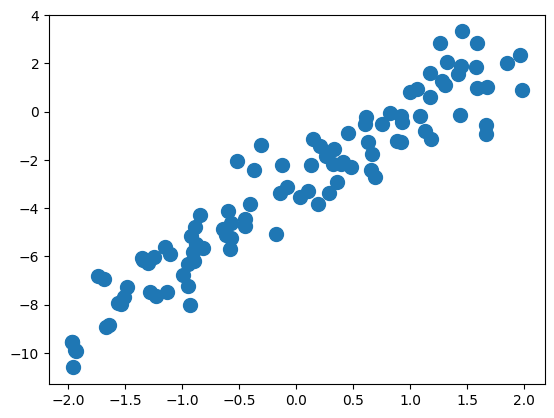

In [2]:
n = 100

a_star = 3.
b_star = -3.
noise_std = 1

x = (np.random.rand(n, 1) - 0.5) * 4
noise = np.random.normal(0, noise_std, (n, 1))
y = a_star * x + b_star + noise

x = torch.tensor(x, dtype=torch.float32)

xvec = x
plt.plot(x, y, 'o', markersize=10)

### Constuire l'optimizer

- Avec torch.nn.Parameter(), créer le paramètre beta qui sera optimisé. Les predictions du modèle sont égales à $\beta \times X$ 
- Avec torch.nn.MSELoss, déclarer la loss entre les prédictions et le résultat réel. loss.backward() pour mettre à jour les gradients
- Avec torch.optim.Adam, déclarer un optimizer
- Construisez la boucle qui, pour n_epochs, va reset les gradients, calculer la loss, mettre à jour les gradients et faire un pas pour optimiser beta

In [3]:
y = torch.tensor(y, dtype=torch.float32)

n_epochs = 1000

l_rates = 0.01

beta = torch.nn.Parameter(torch.randn(1, 1, requires_grad=True))

criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam([beta], lr=l_rates)

for epoch in range(n_epochs):
    optimizer.zero_grad()

    predictions = beta * x

    loss = criterion(predictions, y)

    loss.backward()

    optimizer.step()

    if epoch % 100 == 0:
        print(f'Époque {epoch}: Loss = {loss.item()}')

Époque 0: Loss = 14.100214004516602
Époque 100: Loss = 11.452899932861328
Époque 200: Loss = 10.80154800415039
Époque 300: Loss = 10.720458984375
Époque 400: Loss = 10.715705871582031
Époque 500: Loss = 10.715576171875
Époque 600: Loss = 10.715575218200684
Époque 700: Loss = 10.715575218200684
Époque 800: Loss = 10.715575218200684
Époque 900: Loss = 10.715575218200684


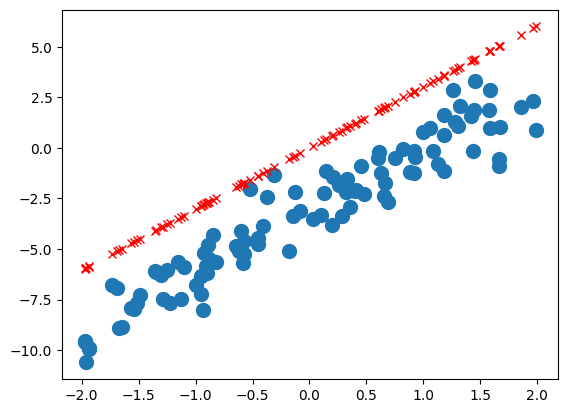

In [4]:
# Plot des predictions
plt.plot(x, y, 'o', markersize=10)
plt.plot(x, beta.item() * x, 'rx')


## Construire un multi-layer perceptron (MLP)

Ici, les données sont $y = a x^2 + b$

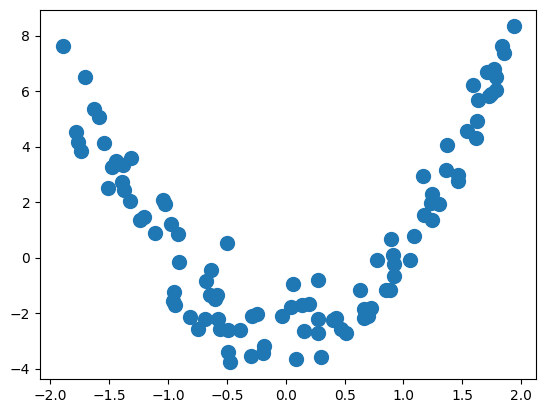

In [5]:
n = 100

a_star = 3.
b_star = -3.
noise_std = 1

x = (np.random.rand(n, 1) - 0.5) * 4
noise = np.random.normal(0, noise_std, (n, 1))
y = a_star * (x ** 2) + b_star + noise

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

xvec = x
plt.plot(x, y, 'o', markersize=10)

Nous allons construire un Pytorch modèle. Dans ce framework, on définit la fonction "forward" qui prend en argument les inputs et retourne les prédictions.

A l'aide de torch.nn.Module et de différentes layers (torch.nn.Linear, torch.nn.ReLU), terminez la classe ci-dessous pour créer un multi-layers perceptron 

In [6]:
class MLP(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()

        hidden_size = 64
        self.layer = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(hidden_size, 1)

    def forward(self, X):
        X = self.layer(X)
        X = self.relu(X)
        X = self.layer2(X)
        
        return X

En utilisant le travail précédent, faite une cellule utilisant un torch optimizer pour optimiser le MLP 

In [7]:
l_rates = 0.01
n_epochs = 1000

model = MLP(input_size=1)

loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=l_rates)

for epoch in range(n_epochs):
    optimizer.zero_grad()

    predictions = model(x)

    loss = loss_fn(predictions, y)

    loss.backward()

    optimizer.step()

    if epoch % 100 == 0:
        print(f'Époque {epoch}: Loss = {loss.item()}')

Époque 0: Loss = 11.735764503479004
Époque 100: Loss = 1.2780386209487915
Époque 200: Loss = 0.9301242232322693
Époque 300: Loss = 0.8676371574401855
Époque 400: Loss = 0.8230825066566467
Époque 500: Loss = 0.7930393815040588
Époque 600: Loss = 0.773903489112854
Époque 700: Loss = 0.7610293030738831
Époque 800: Loss = 0.752888560295105
Époque 900: Loss = 0.7476769089698792


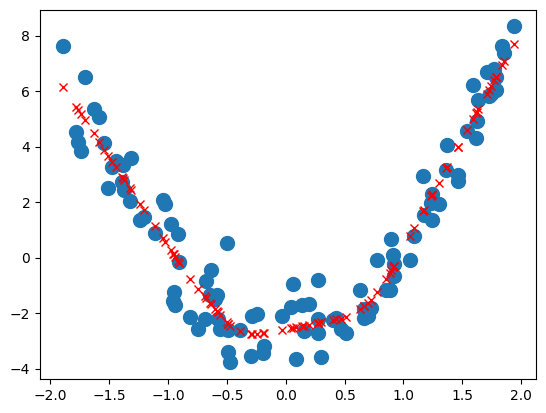

In [8]:
# Plot des predictions
plt.plot(x, y, 'o', markersize=10)
plt.plot(x, model(x).detach(), 'rx')

## Construire un Recurrent Neural Network (RNN) from scratch

### Données
 
Téléchargez [ici](https://download.pytorch.org/tutorial/data.zip) un jeu de données "nom" -> pays d'origine du nom.
Les noms de chaque pays sont dans leur fichier texte "[country].txt"

A partir de ces données, créez X la liste des noms et y le pays d'origine de chaque nom

### Aide pour générer les données

A la fin de ce code, on lit les noms et leur pays d'origine.<br>
On a une fonction randomTrainingExample, qui génère le pays d'origine et le nom (en texte), puis l'ID de ce pays et le tenseur représetant le nom. <br>

A partir de là, vous pouvez générer les données X, y comme vous voulez

In [9]:
# Code pour générer le jeu de données
# En admettant que les fichiers ont été extraits dans data/raw/names/

import math
import numpy as np
from pathlib import Path
import random
import string
import time
import unicodedata
import matplotlib.pyplot as plt

path = Path("../src/data/raw/names/")

In [10]:
def read_names(path):
    category_lines = {}
    for file in path.iterdir():
        if not file.name.endswith(".txt"):
            continue
            
        with open(file) as f:
            names = [unicodeToAscii(line.strip()) for line in f]
        
        category = file.stem
        category_lines[category] = names

    return category_lines

# Handling ASCII stuff
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [11]:
category_lines = read_names(path) # names per language
all_categories = list(category_lines.keys()) # languages
n_categories = len(all_categories) 

In [12]:
category_lines

{'Arabic': ['Khoury',
  'Nahas',
  'Daher',
  'Gerges',
  'Nazari',
  'Maalouf',
  'Gerges',
  'Naifeh',
  'Guirguis',
  'Baba',
  'Sabbagh',
  'Attia',
  'Tahan',
  'Haddad',
  'Aswad',
  'Najjar',
  'Dagher',
  'Maloof',
  'Isa',
  'Asghar',
  'Nader',
  'Gaber',
  'Abboud',
  'Maalouf',
  'Zogby',
  'Srour',
  'Bahar',
  'Mustafa',
  'Hanania',
  'Daher',
  'Tuma',
  'Nahas',
  'Saliba',
  'Shamoon',
  'Handal',
  'Baba',
  'Amari',
  'Bahar',
  'Atiyeh',
  'Said',
  'Khouri',
  'Tahan',
  'Baba',
  'Mustafa',
  'Guirguis',
  'Sleiman',
  'Seif',
  'Dagher',
  'Bahar',
  'Gaber',
  'Harb',
  'Seif',
  'Asker',
  'Nader',
  'Antar',
  'Awad',
  'Srour',
  'Shadid',
  'Hajjar',
  'Hanania',
  'Kalb',
  'Shadid',
  'Bazzi',
  'Mustafa',
  'Masih',
  'Ghanem',
  'Haddad',
  'Isa',
  'Antoun',
  'Sarraf',
  'Sleiman',
  'Dagher',
  'Najjar',
  'Malouf',
  'Nahas',
  'Naser',
  'Saliba',
  'Shamon',
  'Malouf',
  'Kalb',
  'Daher',
  'Maalouf',
  'Wasem',
  'Kanaan',
  'Naifeh',
  'Boutro

In [13]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [14]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Arabic / line = Attia
category = German / line = Brune
category = English / line = Seymour
category = Dutch / line = Penners
category = Dutch / line = Lauwens
category = French / line = Pelletier
category = Dutch / line = Venn
category = Russian / line = Agatov
category = French / line = Sartre
category = Japanese / line = Saitoh


### Construire le RNN

Un Recurrent Neural Network prend, pour prédire un input X et un hidden state H.<br>
Il output une prédiction et un nouvel hidden state pour la prochaine étape.<br>
Nous allons construire un modèle:

$f(name, H_0) = (proba(\mbox{name from country 0}), proba(\mbox{name from country 1}), \dots)$

Avec $H_0$ un hidden state initial (qui sera appris).

Pour l'instant, nous allons construire un RNN linéaire.<br>
Comme pour le MLP, construisez un torch.nn.Module:
- A l'init, la classe prendra les arguments input_size, hidden_state_dim, output_size
- L'init déclare un paramètre pour l'hidden state initial $H_0$, une layer linéaire prenant (input, hidden_state) -> output_size
- Le forward fonctionnera ainsi:
    - hidden_state = $H_0$
    - For letter in name:
        - x = one-hot encode (letter)
        - output, hidden_state = linear_layer(x, hidden_state)
    - return softmax(output)


In [15]:
class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = torch.nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = torch.nn.Linear(hidden_size, output_size)
        self.softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def train(self, category_tensor, line_tensor, criterion, learning_rate=0.005):
        hidden = self.initHidden()

        self.zero_grad()

        for i in range(line_tensor.size()[0]):
            output, hidden = self(line_tensor[i], hidden)

        loss = criterion(output, category_tensor)
        loss.backward()

        for p in self.parameters():
            p.data.add_(p.grad.data, alpha=-learning_rate)

        return output, loss.item()

A l'aide de la negative log likelihood (torch.nn.NLLLoss), construisez une boucle optimisant ce modèle (optimizer, itération au sein des examples).

**Attention 1:** Ici, on n'a pas des tenseurs X, y. On va prendre les exemples 1 par 1.<br>
**Attention 2:** Si le modèle apprend les examples dans l'ordre (d'abord tous les noms arabes, puis tous les chinois, puis tous les tchèques, etc), cela changera grandement le résulat (et le modèle sera très mauvais)

In [16]:
l_rates = 0.003
n_epochs = 100000

hidden_size = 128
output_size = n_categories


model = RNN(input_size=n_letters, hidden_size=hidden_size, output_size=output_size)

criterion = torch.nn.NLLLoss()

current_loss = 0
all_losses = []

for epoch in range(1, n_epochs + 0):
    category, line, category_tensor, line_tensor = randomTrainingExample()

    output, loss = model.train(category_tensor, line_tensor, criterion, learning_rate=l_rates)

    current_loss += loss

    if epoch % 5000 == 0:
        print(f'Époque {epoch}: Loss = {loss}')
        all_losses.append(current_loss / 5000)
        current_loss = 0


Époque 5000: Loss = 2.9216039180755615
Époque 10000: Loss = 2.1010944843292236
Époque 15000: Loss = 1.974325180053711
Époque 20000: Loss = 1.869903802871704
Époque 25000: Loss = 1.2935434579849243
Époque 30000: Loss = 1.7384166717529297
Époque 35000: Loss = 2.1966214179992676
Époque 40000: Loss = 0.2761259078979492
Époque 45000: Loss = 0.23672516644001007
Époque 50000: Loss = 0.020392287522554398
Époque 55000: Loss = 1.1655477285385132
Époque 60000: Loss = 0.80597984790802
Époque 65000: Loss = 3.2322888374328613
Époque 70000: Loss = 0.06843314319849014
Époque 75000: Loss = 1.6820015907287598
Époque 80000: Loss = 2.3516180515289307
Époque 85000: Loss = 1.725996971130371
Époque 90000: Loss = 1.174887776374817
Époque 95000: Loss = 1.978714942932129


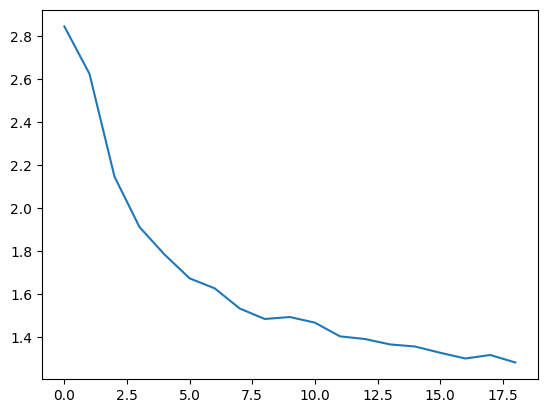

In [17]:
plt.figure()
plt.plot(all_losses)

## Utilisez les RNNs de Pytorch

Sur le même jeu de données, nous allons utiliser les RNNs déjà codés par Pytorch.<br>

### Padding

Nous voulons aussi utiliser des tenseurs X et y pour utiliser data loader pour les batchs, etc


Avec du padding, créer un tenseur X de la taille (nb_data, name_max_length, vocab_size). <br>
X[i, j, :] contient le one-hot encode de la j-ème lettre du i-ème prénom. Si le i-ème prénom a moins de j lettre, alors X[i, j, :] est un vecteur nul

In [18]:
name_max_length = 19

last_names = []

vocab = {letter: index for index, letter in enumerate("abcdefghijklmnopqrstuvwxyz', ")}

vocab2 = {letter: index for index, letter in enumerate("ABCDEFGHIJKLMNOPQRSTUVWXYZ")}

vocab_size = len(vocab)

vocab.update(vocab2)

country_to_index = {country: index for index, country in enumerate(category_lines.keys())}

for country, names in category_lines.items():
    last_names.extend([(country, name) for name in names])

nb_data = len(last_names)

X = np.zeros((nb_data, name_max_length, vocab_size), dtype=np.float32)
Y = np.zeros((nb_data, n_categories))

for i, (country, name) in enumerate(last_names):
    for j, letter in enumerate(name):
        if j >= name_max_length:
            raise ValueError(f"Name {name} is too long")
        if letter in vocab:
            X[i, j, vocab[letter]] = 1.0
        else:
            print(f"Letter {letter} not in vocab")

    Y[i][country_to_index[country]] = 1.0

X = torch.Tensor(X)
Y = torch.Tensor(Y)

Y = Y.type(torch.LongTensor)

print(X.shape)
print(Y.shape)

torch.Size([20074, 19, 29])
torch.Size([20074, 18])


### Modèle

Construisez un modèle qui:
- A l'init, déclare un hidden state initial $H_0$, un RNN (avec torch.nn.RNN)
- Au forward, passe (input, $H_0$) dans le RNN, puis applique un softmax à l'output

In [19]:
class RNNModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = torch.nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)
        self.softmax = torch.nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)

        return out

In [20]:
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

Entraînez le modèle avec des batchs de X, y

In [21]:
input_size = vocab_size
hidden_size = 64
output_size = n_categories
batch_size = 64
learning_rate = 0.001
num_epochs = 100

In [22]:
dataset = CustomDataset(X, Y)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [23]:
model = RNNModel(input_size, hidden_size, output_size)

criterion = torch.nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
all_losses = []

for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = criterion(outputs, torch.max(labels, 1)[1])
        
        loss.backward()
        optimizer.step()
    if epoch % 5 == 0:
        print(f'Epoch {epoch}: Loss = {loss.item()}')
    all_losses.append(loss.item())

Epoch 0: Loss = 2.0350584983825684
Epoch 5: Loss = 1.742136836051941
Epoch 10: Loss = 1.8751918077468872
Epoch 15: Loss = 1.7373403310775757
Epoch 20: Loss = 2.065960645675659
Epoch 25: Loss = 1.689512014389038
Epoch 30: Loss = 2.01037859916687
Epoch 35: Loss = 1.8900835514068604
Epoch 40: Loss = 1.3074721097946167
Epoch 45: Loss = 1.406745195388794
Epoch 50: Loss = 1.0909206867218018
Epoch 55: Loss = 1.1998118162155151
Epoch 60: Loss = 1.2748321294784546
Epoch 65: Loss = 1.126526117324829
Epoch 70: Loss = 0.822089672088623
Epoch 75: Loss = 0.9281584620475769
Epoch 80: Loss = 1.159080147743225
Epoch 85: Loss = 1.2210885286331177
Epoch 90: Loss = 0.9491786956787109
Epoch 95: Loss = 1.0825881958007812


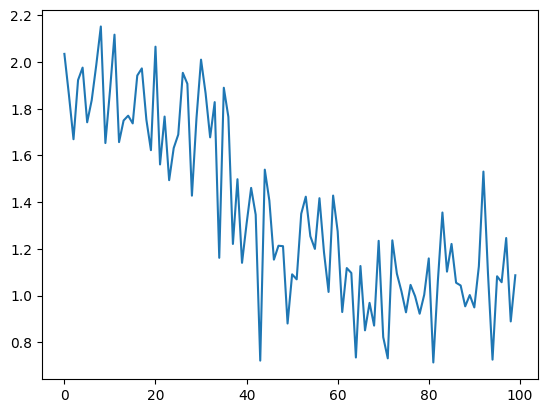

In [25]:
plt.figure()
plt.plot(all_losses)

### Amélioration du modèle

Tenter d'améliorer le modèle:
- En utilisant plusieurs layers dans le RNN
- En utilisant LSTM à la place de RNN (une autre forme de recurrent neural network, plus avancé)

(regardez la doc)

In [26]:
class LSTMModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)
        self.softmax = torch.nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        
        return out

In [27]:
input_size = vocab_size
hidden_size = 64
num_layers = 2
output_size = n_categories
batch_size = 64
learning_rate = 0.001
num_epochs = 100

In [28]:
dataset = CustomDataset(X, Y)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [29]:
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

criterion = torch.nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [30]:
all_losses = []

for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = criterion(outputs, torch.max(labels, 1)[1])
        
        loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        print(f'Epoch {epoch}: Loss = {loss.item()}')
        
    all_losses.append(loss.item())

Epoch 0: Loss = 1.4359309673309326
Epoch 5: Loss = 1.4866727590560913
Epoch 10: Loss = 0.7920907139778137
Epoch 15: Loss = 0.8085365295410156
Epoch 20: Loss = 0.6022078394889832
Epoch 25: Loss = 0.39098992943763733
Epoch 30: Loss = 0.4310320317745209
Epoch 35: Loss = 0.31490358710289
Epoch 40: Loss = 0.5649239420890808
Epoch 45: Loss = 0.5456052422523499
Epoch 50: Loss = 0.2929581105709076
Epoch 55: Loss = 0.29756978154182434
Epoch 60: Loss = 0.13422520458698273
Epoch 65: Loss = 0.23394103348255157
Epoch 70: Loss = 0.2963393032550812
Epoch 75: Loss = 0.1873481571674347
Epoch 80: Loss = 0.05493366718292236
Epoch 85: Loss = 0.1358339488506317
Epoch 90: Loss = 0.048998214304447174
Epoch 95: Loss = 0.21866489946842194


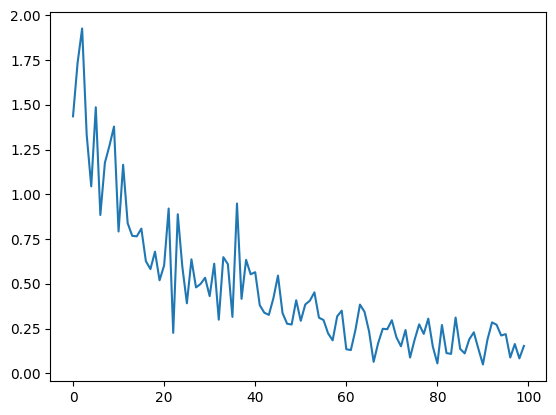

In [31]:
plt.figure()
plt.plot(all_losses)

### Embedding

On veut utiliser en embedding pour les lettres.
Le forward appliquerait l'embedding aux lettres, puis les layers RNN prendrait l'embedding comme input

Nous allons utiliser torch.nn.Embedding
**Attention**: Embedding ne prend pas les lettres one-hot encoded, mais leurs indices.
Par exemple, "abca", il lui faudrait le vecteur [0, 1, 2, 0]<br>
et non [[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]]

**Expérimenter torch.nn.Embedding**<br>
Instantier "emb" une torch.nn.Embedding avec les bons paramètres (regardez la doc)
En construisant le bon tenseur X_emb,

```emb(X_emb)```

doit retourner un tenseur (qui n'a pas de sens car il n'a rien appris pour l'instant, mais les opérations se passent bien)

In [32]:
X_indices = [0, 1, 2, 0]

alphabet_size = 29
embedding_dim = 10 

emb = torch.nn.Embedding(alphabet_size, embedding_dim)

X_index_tensor = torch.tensor(X_indices, dtype=torch.long)

X_emb = emb(X_index_tensor)

print(X_emb)

tensor([[-0.1209, -1.0439, -0.4011, -0.6432, -1.0290, -1.2439,  0.4739, -0.4565,
          1.2182, -1.6821],
        [ 0.4462,  0.4914,  0.3392,  0.7454,  0.1453,  1.2737, -0.6840,  0.6220,
          2.1317, -1.0766],
        [ 0.2246, -0.5866, -0.8515,  0.6089,  0.4805,  0.1572, -0.7420, -0.1016,
         -1.1670,  0.3522],
        [-0.1209, -1.0439, -0.4011, -0.6432, -1.0290, -1.2439,  0.4739, -0.4565,
          1.2182, -1.6821]], grad_fn=<EmbeddingBackward0>)


Construisez un modèle RNN, où les lettres passent par l'embedding avant d'être envoyées dans les couches de RNN.
Construisez une loop d'apprentissage

Expérimentez plusieurs valeurs pour le nombre de couche, la taille d'embedding ou les tailles d'hidden state.<br>
Quel neg log likelihood obtenez-vous ?

In [33]:
name_max_length = 19

last_names = []

vocab = {letter: index for index, letter in enumerate("abcdefghijklmnopqrstuvwxyz', ")}

vocab2 = {letter: index for index, letter in enumerate("ABCDEFGHIJKLMNOPQRSTUVWXYZ")}

vocab_size = len(vocab)

vocab.update(vocab2)

country_to_index = {country: index for index, country in enumerate(category_lines.keys())}

for country, names in category_lines.items():
    last_names.extend([(country, name) for name in names])

nb_data = len(last_names)

X = np.zeros((nb_data, name_max_length))
Y = []

for i, (country, name) in enumerate(last_names):
    for j, letter in enumerate(name):
        if j >= name_max_length:
            raise ValueError(f"Name {name} is too long")
        if letter in vocab:
            X[i, j] = vocab[letter]
        else:
            print(f"Letter {letter} not in vocab")

    Y.append(country_to_index[country])

X = torch.Tensor(X)
Y = torch.Tensor(Y)

X = X.type(torch.LongTensor)
Y = Y.type(torch.LongTensor)

print(X.shape)
print(Y.shape)

torch.Size([20074, 19])
torch.Size([20074])


In [34]:
from torch.utils.data.dataset import random_split


class RNNWithEmbedding(torch.nn.Module):
    def __init__(self, alphabet_size, embedding_dim, hidden_size, num_layers, output_size):
        super(RNNWithEmbedding, self).__init__()
        self.embedding = torch.nn.Embedding(alphabet_size, embedding_dim)
        self.rnn = torch.nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)
        self.softmax = torch.nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        
        return out
    
    def launch_training(self, X, Y, criterion, optimizer, batch_size=64, num_epochs=100, validation_split=0.2, shuffle_dataset=True):

        dataset = CustomDataset(X, Y)

        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle_dataset)

        total_size = len(dataloader.dataset)
        train_size = int((1 - validation_split) * total_size)
        val_size = total_size - train_size

        train_dataset, val_dataset = random_split(dataloader.dataset, [train_size, val_size])

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        train_losses = []
        val_losses = []

        for epoch in range(num_epochs):
            for inputs, labels in train_dataloader:
                optimizer.zero_grad()
                
                outputs = self(inputs)
                
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

            # Evaluation
            self.eval()
            with torch.no_grad():
                for inputs, labels in val_dataloader:
                    outputs = self(inputs)
                    val_loss = criterion(outputs, labels)
                    
            self.train()
            
            if epoch % 5 == 0:
                print(f'Epoch {epoch}: Training Loss = {loss.item()} - Val Loss = {val_loss.item()}')
                
            train_losses.append(loss.item())
            val_losses.append(val_loss.item())
        
        return train_losses, val_losses

In [35]:
alphabet_size = vocab_size
output_size = n_categories
num_epochs = 100
batch_size = 64

learning_rate = 0.001
embedding_dim = 32
hidden_size = 64
num_layers = 2

In [36]:
model = RNNWithEmbedding(alphabet_size, embedding_dim, hidden_size, num_layers, output_size)

criterion = torch.nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [37]:
def print_plots(train_losses, val_losses):
    iterations = range(1, len(train_losses) + 1)

    plt.plot(iterations, train_losses, label='Train Loss')
    plt.plot(iterations, val_losses, label='Validation Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')

Model Numéro 1: 2 couches de 64 hidden state, 32 embedding<br>

In [38]:
train_losses, val_losses = model.launch_training(X, Y, criterion, optimizer, batch_size, num_epochs)

Epoch 0: Training Loss = 1.8711718320846558 - Val Loss = 2.135714530944824
Epoch 5: Training Loss = 0.9624544978141785 - Val Loss = 0.8898573517799377
Epoch 10: Training Loss = 0.5125969648361206 - Val Loss = 0.6130734086036682
Epoch 15: Training Loss = 0.45265185832977295 - Val Loss = 0.6493957042694092
Epoch 20: Training Loss = 0.5531095862388611 - Val Loss = 0.5509294867515564
Epoch 25: Training Loss = 0.16994303464889526 - Val Loss = 0.8331193327903748
Epoch 30: Training Loss = 0.2926810085773468 - Val Loss = 0.9982379078865051
Epoch 35: Training Loss = 0.20086997747421265 - Val Loss = 0.9864220023155212
Epoch 40: Training Loss = 0.10107162594795227 - Val Loss = 1.2065643072128296
Epoch 45: Training Loss = 0.11911460012197495 - Val Loss = 1.537320613861084
Epoch 50: Training Loss = 0.23946593701839447 - Val Loss = 1.7131060361862183
Epoch 55: Training Loss = 0.11032713204622269 - Val Loss = 1.4997272491455078
Epoch 60: Training Loss = 0.032434698194265366 - Val Loss = 1.44902348518

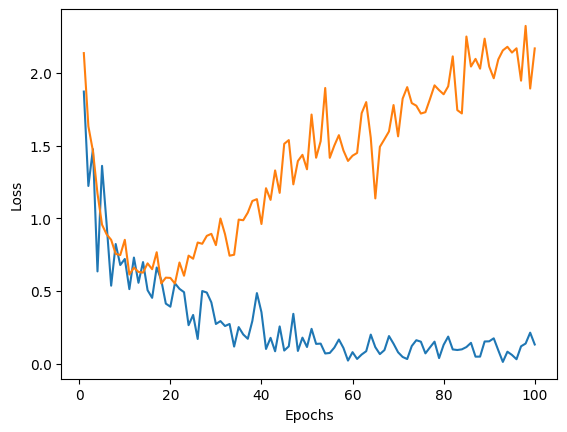

In [39]:
print_plots(train_losses, val_losses)

Overfitting<br>

Model Numéro 2: 2 couches de 128 hidden state, 128 embedding<br>

In [40]:
learning_rate = 0.0005
embedding_dim = 128
hidden_size = 128
num_layers = 2

In [41]:
model = RNNWithEmbedding(alphabet_size, embedding_dim, hidden_size, num_layers, output_size)

criterion = torch.nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [42]:
train_losses, val_losses = model.launch_training(X, Y, criterion, optimizer, batch_size, num_epochs)

Epoch 0: Training Loss = 1.2572128772735596 - Val Loss = 1.486046314239502
Epoch 5: Training Loss = 0.5920065641403198 - Val Loss = 0.7245097756385803
Epoch 10: Training Loss = 0.779015064239502 - Val Loss = 0.6506187915802002
Epoch 15: Training Loss = 0.37398821115493774 - Val Loss = 0.6298273205757141
Epoch 20: Training Loss = 0.22569145262241364 - Val Loss = 0.6697048544883728
Epoch 25: Training Loss = 0.2890431880950928 - Val Loss = 0.7287613153457642
Epoch 30: Training Loss = 0.11163888871669769 - Val Loss = 0.8886684775352478
Epoch 35: Training Loss = 0.18945270776748657 - Val Loss = 0.9171874523162842
Epoch 40: Training Loss = 0.07748866826295853 - Val Loss = 0.7419905066490173
Epoch 45: Training Loss = 0.08295486122369766 - Val Loss = 0.7097206115722656
Epoch 50: Training Loss = 0.12103500962257385 - Val Loss = 0.8227388262748718
Epoch 55: Training Loss = 0.07813780009746552 - Val Loss = 1.1482709646224976
Epoch 60: Training Loss = 0.2185099720954895 - Val Loss = 0.770393967628

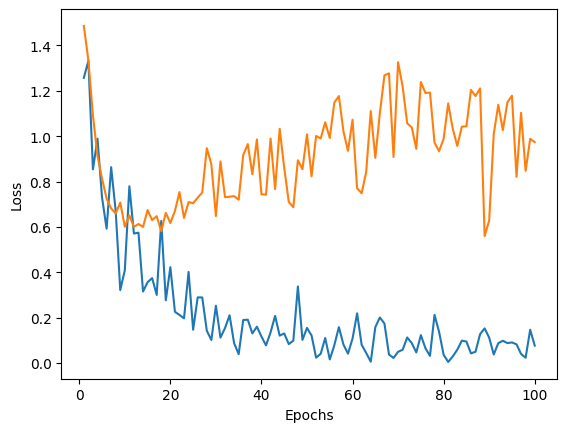

In [43]:
print_plots(train_losses, val_losses)